# Bayesian Radial Velocity Planet Search

One area in astronomy where Bayesian approaches have been applied with great success is in the hunt for extrasolar planets.
There are several benefits of Bayesian modeling in this situation. In particular:

1. Bayesian modeling can account for the many nuisance parameters typical in a planet search. For example, when seeking evidence of a planet around a star, we need our model to account for things like the phase and the longitude of periastron, but we don't necessarily care about these parameters in the end.

2. Often we have very important prior information – for example, we might have a very good constraint on the period from eclipse data, and use this to model orbital parameters with radial velocity data.

3. The forward-modeling aspect of Bayesian approaches can be advantageous when dealing with detectors that have strong systematic uncertainties. For example, this idea is key to some of the recent analysis of K2 data.

Here we'll take a look at a Bayesian approach to determining orbital parameters of a planet from radial velocity (RV) measurements.
We'll start with some generated data in which we know the correct answer, and then take a look at some real RV measurements from the literature.

## Preliminaries

As usual, we start with some imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set() #nice plot formatting

## The Radial Velocity Model

The first important step is to define a mathematical (and computational) model of how the parameters of interest are reflected in our observations.

Some references relating to what we're going to compute below:

- Balan 2009: http://adsabs.harvard.edu/abs/2009MNRAS.394.1936B
- Exofit Manual: http://www.star.ucl.ac.uk/~lahav/ExoFitv2.pdf
- Hou 2014: http://arxiv.org/pdf/1401.6128.pdf

The equation for radial velocity is this:

$$
v(t) = V - K[ \sin(f + \omega) + e \sin(\omega)]
$$

where $V$ is the overall velocity of the system, and

$$
K = \frac{m_p}{m_s + m_p} \frac{2\pi}{T}\frac{a \sin i}{\sqrt{1 - e^2}}
$$

The true anomaly $f$ satisfies

$$
\cos(f) = \frac{\cos(E) - e}{1 - e\cos E}
$$

Rearranging this we can write
$$
f = 2 \cdot{\rm atan2}\left(\sqrt{1 + e}\sin(E/2), \sqrt{1 - e} \cos(E/2)\right)
$$

The eccentric anomaly $E$ satisfies
$$
M = E - e\sin E
$$

and the mean anomaly is
$$
M = \frac{2\pi}{T}(t + \tau)
$$

and $\tau$ is the time of pericenter passage, which we'll parametrize with the parameter $\chi = \tau /  T$

These are the parameters needed to compute the radial velocity:

- $T$: orbital period
- $K$: amplitude of RV oscillation
- $V$: secular offset of RV oscillation
- $e$: eccentricity
- $\omega$: longitude of periastron
- $\chi$: dimensionless phase offset

Additionally, we will fit a scatter parameter $s$ which accounts for global data errors not reflected in the reported uncertainties (this is very similar to the third parameter from the linear fit we saw earlier)

For convenience, we'll store these parameters in a ``namedtuple``:

In [2]:
from collections import namedtuple
params = namedtuple('params', ['T', 'e', 'K', 'V', 'omega', 'chi', 's'])

Here is a function to compute the observed radial velocity as a function of these parameters:

In [3]:
from scipy import optimize

@np.vectorize
def compute_E(M, e):
    """Solve Kepler's eqns for eccentric anomaly given mean anomaly"""
    f = lambda E, M=M, e=e: E - e * np.sin(E) - M
    return optimize.brentq(f, 0, 2 * np.pi)


def radial_velocity(t, theta):
    """Compute radial velocity given orbital parameters"""
    T, e, K, V, omega, chi = theta[:6]
    
    # compute mean anomaly (0 <= M < 2pi)
    M = 2 * np.pi * ((t / T + chi) % 1)
    
    # solve for eccentric anomaly
    E = compute_E(M, e)
    
    # compute true anomaly
    f = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                       np.sqrt(1 - e) * np.cos(E / 2))
    
    # compute radial velocity
    return V - K * (np.sin(f + omega) + e * np.sin(omega))

Just to get a sense of whether we've done this correctly, let's use IPython's interactive features to see how the parameters change the observed RV curve (you may have to first ``pip install ipywidgets``)

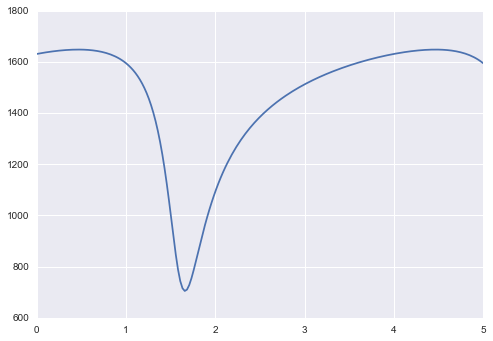

In [4]:
from ipywidgets import interact

def plot_RV(T, e, K, V, omega, chi):
    t = np.linspace(0, 5, 200)
    theta = [T, e, K, V, omega, chi]
    plt.plot(t, radial_velocity(t, theta))
    
interact(plot_RV,
         T=(0, 5.), K=(0, 2000.), V=(-2000., 2000.),
         e=(0, 1.), omega=(0, 2 * np.pi), chi=(0, 1.));

The model seems to be working as expected!

## Fitting Simulated Data

Now let's generate some simulated data so that we can explore a Bayesian approach to modeling the radial velocity effects of a planet orbiting a star.
We'll choose some reasonable parameters and create some data:

In [5]:
theta_sim = params(T=700, e=0.38, K=60, V=12,
                   omega=3.10, chi=0.67, s=1)
Nobs = 50

rng = np.random.RandomState(0)
t_sim = 1400 + 600 * rng.rand(Nobs)
err_sim = 5 + 5 * rng.rand(Nobs)
rv_sim = radial_velocity(t_sim, theta_sim) + err_sim * rng.randn(Nobs)

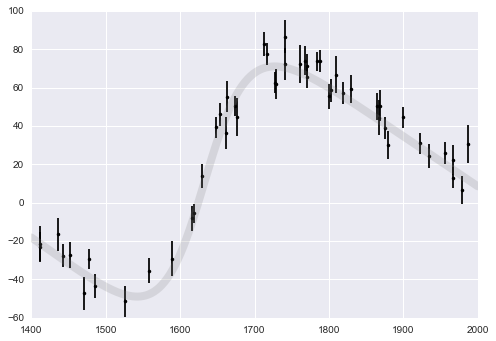

In [6]:
plt.errorbar(t_sim, rv_sim, err_sim, fmt='.k');
xlim = plt.xlim()
t_fit = np.linspace(xlim[0], xlim[1], 500)
plt.plot(t_fit, radial_velocity(t_fit, theta_sim), color='gray', lw=8, alpha=0.2);

## Bayesian Fit

Next let's use ``emcee`` to do a Bayesian model fit to this data.
We'll follow some of the references above and use a flat prior on most parameters, and a Jeffreys Prior on the scale factors:

In [7]:
theta_lim = params(T=(0.2, 2000),
                   e=(0, 1),
                   K=(0.01, 2000),
                   V=(-2000, 2000),
                   omega=(0, 2 * np.pi),
                   chi=(0, 1),
                   s=(0.001, 100))
theta_min, theta_max = map(np.array, zip(*theta_lim))

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf # log(0)
    
    # Jeffreys Prior on T, K, and s
    return -np.sum(np.log(theta[[0, 2, 6]]))

def log_likelihood(theta, t, rv, rv_err):
    sq_err = rv_err ** 2 + theta[6] ** 2
    rv_model = radial_velocity(t, theta)
    return -0.5 * np.sum(np.log(sq_err) + (rv - rv_model) ** 2 / sq_err)

def log_posterior(theta, t, rv, rv_err):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return ln_prior + log_likelihood(theta, t, rv, rv_err)

With the likelihood model in place, we can now use ``emcee`` to sample the posterior and view the resulting chains:

In [8]:
import emcee

ndim = len(theta_sim)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# start with theta near the midpoint of the prior range
rng = np.random.RandomState(42)
theta_guess = 0.5 * (theta_min + theta_max)
theta_range = (theta_max - theta_min)
starting_guesses = theta_guess + 0.05 * theta_range * rng.randn(nwalkers, ndim)

# create the sampler; fix the random state for replicability
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t_sim, rv_sim, err_sim))
sampler.random_state = rng

# time and run the MCMC
%time pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

CPU times: user 28.1 s, sys: 723 ms, total: 28.8 s
Wall time: 29.1 s


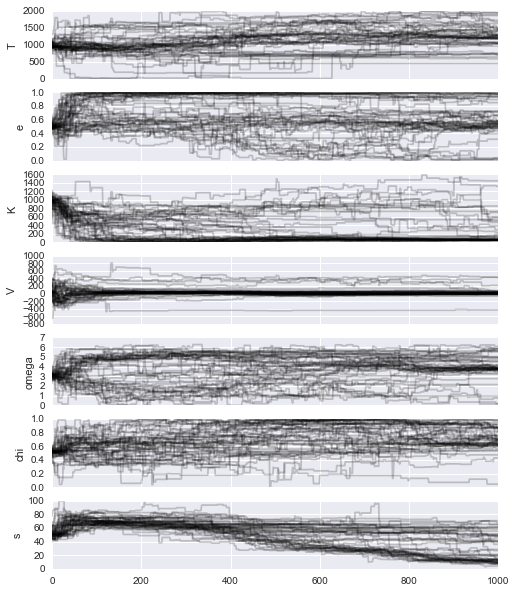

In [9]:
def plot_chains(sampler):
    fig, ax = plt.subplots(7, figsize=(8, 10), sharex=True)
    for i in range(7):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])

plot_chains(sampler)

Yikes! it's all over the place!

The issue here is that our initialization was haphazard and the posterior is extremely multimodal (especially in *T*); given a number of steps approaching infinity, the MCMC algorithm would converge, but we don't have an infinite amount of time to wait! Instead we can more carefully initialize the walkers.

First, let's use a Lomb-Scargle periodogram to find a suitable guess at the period.
The [gatspy](http://www.astroml.org/gatspy/) package has a nice implementation (first you need to ``pip install gatspy``)

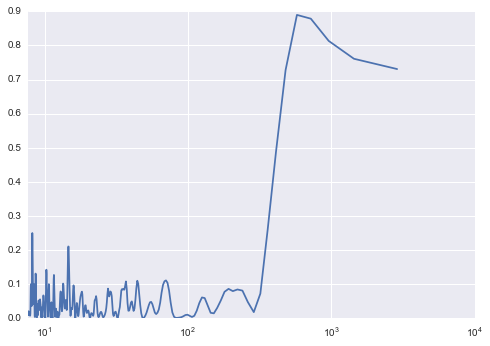

In [14]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast()

model.fit(t_sim, rv_sim, err_sim)
periods, power = model.periodogram_auto()
plt.semilogx(periods, power)
plt.xlim(0, 10000);

Now we can choose a sensible starting point with this period, and with other parameters estimated from the data

In [15]:
def make_starting_guess(t, rv, rv_err):
    model = LombScargleFast()
    model.optimizer.set(period_range=theta_lim.T,
                        quiet=True)
    model.fit(t, rv, rv_err)

    rv_range = 0.5 * (np.max(rv) - np.min(rv))
    rv_center = np.mean(rv)
    return params(T=model.best_period,
                  e=0.1,
                  K=rv_range,
                  V=rv_center,
                  omega=np.pi,
                  chi=0.5,
                  s=rv_err.mean())

theta_guess = make_starting_guess(t_sim, rv_sim, err_sim)
theta_guess

ValueError: The optimizer is not designed to search for for periods larger than the data baseline. 

In [16]:
sampler.reset()
start = theta_guess * (1 + 0.01 * rng.randn(nwalkers, ndim))
pos, prob, state = sampler.run_mcmc(start, 1000)

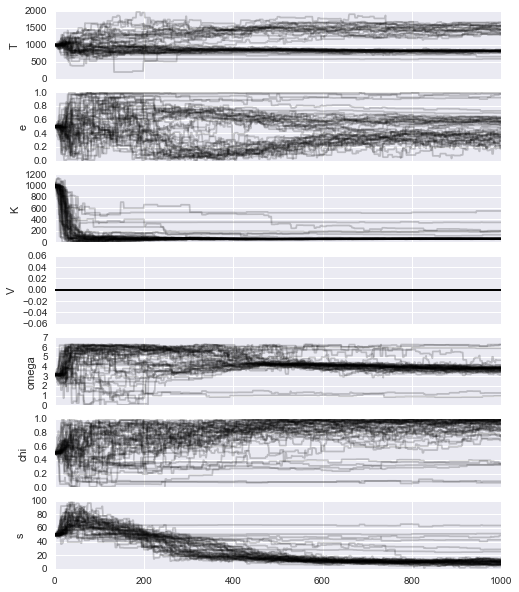

In [17]:
plot_chains(sampler)

Much more reasonable! The trace appears to have stabilized by the end of this, so let's reset and get a clean 1000 samples from the posterior:

In [18]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

Using the [corner.py](https://pypi.python.org/pypi/corner) package, we can take a look at this multi-dimensional posterior, along with the input values for the parameters:

In [19]:
import corner
corner.corner(sampler.flatchain, labels=params._fields, truths=theta_sim);

ValueError: It looks like the parameter(s) in column(s) 3 have no dynamic range. Please provide a `range` argument.

We can view the fit to our data by sampling from the posterior, and computing the model associated with each sample: because the trace already is a sample from the posterior, we can simply draw randomly from these points:

In [ ]:
rng = np.random.RandomState(42)

rv_fit = [radial_velocity(t_fit, sampler.flatchain[i])
          for i in rng.choice(sampler.flatchain.shape[0], 200)]

plt.errorbar(t_sim, rv_sim, err_sim, fmt='.k')
plt.plot(t_fit, np.transpose(rv_fit), '-k', alpha=0.01)
plt.xlabel('time (days)')
plt.ylabel('radial velocity (km/s)');

Finally, we can treat everything but the period and eccentricity as a nuisance parameter (i.e. marginalize over them) and take a look at our parameter constraints:

In [ ]:
import corner
corner.corner(sampler.flatchain[:, :2], 
              labels=params._fields[:2],
              truths=theta_sim[:2]);

This is the marginalized posterior distribution for the period and eccentricity (i.e. integrating over all the other parameters as nuisance parameters).
We see that, as we might hope, the true value lies well withing the uncertainty implied by the marginalized posterior!

## Breakout: 47 Ursae Majoris

Your task now is to repeat this analysis using some real data, which we'll take from table 1 of [Fischer et al 2002](http://iopscience.iop.org/article/10.1086/324336/meta).

If you're curious about one possible solution to this problem, see [Solutions-05](Solutions-05.ipynb). As usual, try to fight the temptation to peek at this until after you've given the problem a reasonable effort!

The following IPython magic command will create the data file ``47UrsaeMajoris.txt`` in the current directory:

In [ ]:
%%file 47UrsaeMajoris.txt
date      rv     rv_err
6959.737  -60.48 14.00
7194.912  -53.60 7.49
7223.798  -38.36 6.14
7964.893  0.60 8.19
8017.730  -28.29 10.57
8374.771  -40.25 9.37
8647.897  42.37 11.41
8648.910  32.64 11.02
8670.878  55.45 11.45
8745.691  51.78 8.76
8992.061  4.49 11.21
9067.771  -14.63 7.00
9096.734  -26.06 6.79
9122.691  -47.38 7.91
9172.686  -38.22 10.55
9349.912  -52.21 9.52
9374.964  -48.69 8.67
9411.839  -36.01 12.81
9481.720  -52.46 13.40
9767.918  38.58 5.48
9768.908  36.68 5.02
9802.789  37.93 3.85
10058.079  15.82 3.45
10068.980  15.46 4.63
10072.012  21.20 4.09
10088.994  1.30 4.25
10089.947  6.12 3.70
10091.900  0.00 4.16
10120.918  4.07 4.16
10124.905  0.29 3.74
10125.823  -1.87 3.79
10127.898  -0.68 4.10
10144.877  -4.13 5.26
10150.797  -8.14 4.18
10172.829  -10.79 4.43
10173.762  -9.33 5.43
10181.742  -23.87 3.28
10187.740  -16.70 4.67
10199.730  -16.29 3.98
10203.733  -21.84 4.92
10214.731  -24.51 3.67
10422.018  -56.63 4.23
10438.001  -39.61 3.91
10442.027  -44.62 4.05
10502.853  -32.05 4.69
10504.859  -39.08 4.65
10536.845  -22.46 5.18
10537.842  -22.83 4.16
10563.673  -17.47 4.03
10579.697  -11.01 3.84
10610.719  -8.67 3.52
10793.957  37.00 3.78
10795.039  41.85 4.80
10978.684  36.42 5.01
11131.066  13.56 6.61
11175.027  -3.74 8.17
11242.842  -21.85 5.43
11303.712  -48.75 4.63
11508.070  -51.65 8.37
11536.064  -72.44 4.73
11540.999  -57.58 5.97
11607.916  -43.94 4.94
11626.771  -39.14 7.03
11627.754  -50.88 6.21
11628.727  -51.52 5.87
11629.832  -51.86 4.60
11700.693  -24.58 5.20
11861.049  14.64 5.33
11874.068  14.15 5.75
11881.045  18.02 4.15
11895.068  16.96 4.60
11906.014  11.73 4.07
11907.011  22.83 4.38
11909.042  23.42 3.78
11910.955  18.34 4.33
11914.067  15.45 5.37
11915.048  24.05 3.82
11916.033  23.16 3.67
11939.969  27.53 5.08
11946.960  21.44 4.18
11969.902  30.99 4.58
11971.894  38.36 5.01
11998.779  33.82 3.93
11999.820  27.52 3.98
12000.858  23.40 4.07
12028.740  37.08 4.95
12033.746  26.28 5.24
12040.759  31.12 3.54
12041.719  34.04 3.45
12042.695  31.38 3.98
12073.723  21.81 4.73

An easy way to load data in this form is the [pandas](http://pandas.pydata.org) package, which implements a DataFrame object (basically, a labeled data table).
Reading the CSV file is a one-line operation:

In [ ]:
import pandas as pd
data = pd.read_csv('47UrsaeMajoris.txt', delim_whitespace=True)
t, rv, rv_err = data.values.T

With this data in hand, you can now start to explore it and search for a planet in the radial wobbles of the star.

### Visualize the Data

In [ ]:
# Fill-in code to visualize the data



### Compute the Periodogram

In [ ]:
# Compute the periodogram to look for significant periodicity



### Initialize and run the MCMC Chain

In [ ]:
# Fill-in your code here



### Plot the chains: have they stabilized?

In [ ]:
# Fill-in your code here



### If necessary, reset and re-run the sampler

In [ ]:
# Fill-in your code here



### Make a Corner Plot for the Parameters

In [ ]:
# Fill-in your code here



### Plot the Model Fits over the Data

In [ ]:
# Fill-in your code here



### Results: Report your (joint) uncertainties on period and eccentricity

In [ ]:
# Fill-in your code here



## Extra Credit

If you finish early, try tackling this...

The source of the above data is a paper which actually reports *two* detected planets. Build a Bayesian model which models both of them at once: can you find signals from both planets in the data?